In [1]:
import torch
import torchvision.datasets as datasets
from torchvision.transforms import v2
import torch.utils.data as dataloader
import torch.nn as nn
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
PROJECT_NAME = 'mlp_cifar10_pytorch'
PROJECT_ENTITY = 'cs20b013-bersilin'

# Labels for the CIFAR-10 dataset

LABELS = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

In [3]:
# Create transform to a CIFAR image to a tensor of type float32

transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

In [4]:
# Loading the CIFAR-10 dataset

def load_data(transform: v2.Compose):
    '''
    Load the CIFAR-10 dataset
    '''
    train_data = datasets.CIFAR10(root='./data', 
                                  train=True,
                                  download=True, 
                                  transform=transform)

    test_data = datasets.CIFAR10(root='./data',
                                 train=False,
                                 download=True,
                                 transform=transform)

    return train_data, test_data

# Split the training set into a training and validation set

def val_split(train_data, split=0.2, shuffle=True):
    '''
    Split the training set into a training and validation set

    Args:
    train_set: the training set
    split: the proportion of the validation set
    shuffle: whether to shuffle the indices before splitting
    '''
    train_size = len(train_data)
    indices = list(range(train_size))
    split = int(np.floor(split * train_size))

    if shuffle:
        np.random.shuffle(indices)

    train_indices, val_indices = indices[split:], indices[:split]
    train_set = dataloader.Subset(train_data, train_indices)
    val_set = dataloader.Subset(train_data, val_indices)

    return train_set, val_set

# Create a dataloader

def create_dataloader(train_set, val_set, test_set, batch_size):
    '''
    Create a dataloader for the training and test sets
    '''
    train_loader = dataloader.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = dataloader.DataLoader(val_set, batch_size=5 * batch_size, shuffle=False)
    test_loader = dataloader.DataLoader(test_set, batch_size=5 * batch_size, shuffle=False)

    return train_loader, val_loader, test_loader
        

In [5]:
# print size of all the sets passed

def print_info(train_set, val_set, test_set):
    '''
    Print the size of the training, validation and test sets
    '''
    print(f"Training set: {len(train_set)}")
    print(f"Validation set: {len(val_set)}")
    print(f"Test set: {len(test_set)}")

In [6]:
# Show a random image from the dataset

def show_random_image(dataset: datasets.CIFAR10, index: int = None):
    '''
    Shows a random image from the dataset
    '''
    if index is None:
        index = torch.randint(0, len(dataset), (1,)).item()
    else:
        index = index
                
    image, label = dataset[index]
    plt.imshow(image.permute(1, 2, 0)) # change the shape from (3, 32, 32) to (32, 32, 3)
    plt.title(LABELS[label])
    plt.show()

    return index, label

In [7]:
def plot_confusion_matrix(y_true, y_pred):
    '''
    Plot the confusion matrix
    '''
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LABELS.values())
    disp.plot(cmap='Blues', xticks_rotation='vertical')

In [8]:
def plot_accuracies(train_acc, val_acc):
    '''
    Plot the training and validation accuracies
    '''
    plt.plot(train_acc, label='Training accuracy')
    plt.plot(val_acc, label='Validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [22]:
# Architecture of the model - VGG11

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # input size: 3x32x32
        self.sequence1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # size = 64x16x16
        self.sequence2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # size = 128x8x8
        self.sequence3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # size = 256x4x4
        self.sequence4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # size = 512x2x2
        self.sequence5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # size = 512x1x1
        self.fc1 = nn.Linear(512, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 1000)
        self.fc4 = nn.Linear(1000, 10)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        # input size: 3x32x32
        x = self.sequence1(x)
        print(x.size())
        x = self.sequence2(x)
        x = self.sequence3(x)
        x = self.sequence4(x)
        x = self.sequence5(x)
        x = x.view(-1, 512)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.dropout(self.relu(self.fc3(x)))
        x = self.softmax(self.fc4(x))

        return x

In [10]:
def get_accuracy(model, data_loader):
    '''
    Get the accuracy of the model on the data_loader
    '''
    correct, total = 0, 0

    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            _, predicted = torch.max(preds, 1)
            correct += (predicted == y).sum().item()
            total += y.size(0)

    return correct / total

In [11]:
# Training the model

def train(configs,
          train_loader: dataloader.DataLoader,
          val_loader: dataloader.DataLoader,
          criterion: nn.Module,
          optimizer: optim.Optimizer,
          model: nn.Module):
    
    if configs['wandb_log']:
        import wandb
        run = wandb.init(project=PROJECT_NAME, entity=PROJECT_ENTITY, config=configs)
        run.name = f"lr={configs['learning_rate']}_bs={configs['batch_size']}_epochs={configs['num_epochs']}"
        wandb.watch(model, criterion, log='all')

    print('Training the model...')
    print('---------------------')

    val_accuracies, train_accuracies = [], []

    for epoch in range(configs['num_epochs']):
        model.train()
        running_loss = 0.0

        total_iterations = len(train_loader)

        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            
            # change labels to one-hot encoding
            labels = nn.functional.one_hot(labels, num_classes=10).float()

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            if (i != total_iterations-1):
                print(f'Epoch {epoch + 1}, Iteration {i + 1}/{total_iterations}, Loss: {loss.item()}', end='\r')
            else:
                print(f'Epoch {epoch + 1}, Iteration {i + 1}/{total_iterations}, Loss: {loss.item()}')

        print(f'Epoch {epoch + 1} done, Training Loss: {running_loss / len(train_loader)}')

        # Validation loss
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        print(f'Epoch {epoch + 1}, Validation Loss: {val_loss / len(val_loader)}')

        train_accuracy = get_accuracy(model, train_loader)
        val_accuracy = get_accuracy(model, val_loader)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch + 1}, Training Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy} \n')

        if configs['wandb_log']:
            wandb.log({'Epoch:': epoch + 1,
                       'Training Loss': running_loss / len(train_loader),
                       'Validation Loss': val_loss / len(val_loader),
                       'Training Accuracy': train_accuracy,
                       'Validation Accuracy': val_accuracy})

    print('Finished Training')

    if configs['wandb_log']:
        wandb.finish()
    
    return model, configs, train_accuracies, val_accuracies

In [12]:
def get_predicted_labels(model, data_loader):
    '''
    Get the predicted labels of the model on the data_loader
    '''
    predicted_labels = []
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            _, predicted = torch.max(preds, 1)
            predicted_labels.append(predicted)

    assert len(predicted_labels) == len(data_loader) # Check if all the data has been processed

    predicted_labels = torch.cat(predicted_labels, dim=0)

    assert(predicted_labels.size(0) == len(data_loader.dataset)) # Check if the size of the predicted labels is equal to the size of the dataset

    return predicted_labels.to('cpu').numpy()

In [13]:
# Configuration

configs = {
    'batch_size': 256,
    'learning_rate': 0.00001,
    'num_epochs': 10,
    'momentum': 0,

    'wandb_log': False,
    'batch_norm': False
}

In [14]:
def normalize(train_set: datasets.CIFAR10, test_set: datasets.CIFAR10):
    '''
    Normalize the training and test sets
    '''
    mean = train_set.data.mean(axis=(0, 1, 2)) / 255
    std = train_set.data.std(axis=(0, 1, 2)) / 255

    transform = v2.Compose([
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean, std, inplace=True)
    ])

    train_set.transform = transform
    test_set.transform = transform

    return train_set, test_set

In [15]:
train_set, test_set = load_data(transform)

train_set, test_set = normalize(train_set, test_set)

train_set, val_set = val_split(train_set)
train_loader, val_loader, test_loader = create_dataloader(train_set, val_set, test_set, configs['batch_size'])

print_info(train_set, val_set, test_set)

Files already downloaded and verified
Files already downloaded and verified
Training set: 40000
Validation set: 10000
Test set: 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


The size of one image is:  torch.Size([3, 32, 32])
The label of the first image is:  airplane


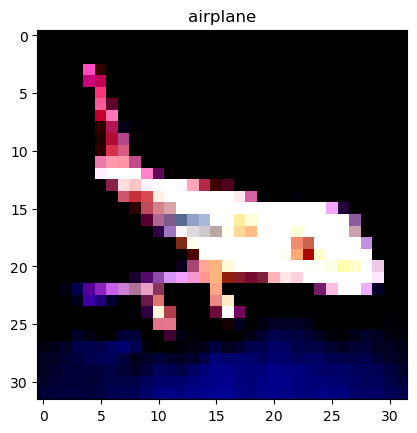

In [16]:
print("The size of one image is: ", train_set[0][0].size())
print("The label of the first image is: ", LABELS[train_set[0][1]])
index, label = show_random_image(train_set, 0)

In [23]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=configs['learning_rate'], momentum=configs['momentum'])

In [20]:
model

CNN(
  (sequence1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (sequence2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (sequence3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (sequence4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ce

In [24]:
model, configs, train_accuracies, val_accuracies = train(configs, train_loader, val_loader, criterion, optimizer, model)
plot_accuracies(train_accuracies, val_accuracies)

Training the model...
---------------------
torch.Size([256, 64, 16, 16])
torch.Size([256, 64, 16, 16])s: 2.302452564239502
torch.Size([256, 64, 16, 16])s: 2.302631139755249
torch.Size([256, 64, 16, 16])s: 2.3026814460754395
torch.Size([256, 64, 16, 16])s: 2.302615165710449
torch.Size([256, 64, 16, 16])s: 2.3026788234710693
torch.Size([256, 64, 16, 16])s: 2.3025197982788086
torch.Size([256, 64, 16, 16])s: 2.302631378173828
torch.Size([256, 64, 16, 16])s: 2.302687406539917
torch.Size([256, 64, 16, 16])s: 2.302582263946533
torch.Size([256, 64, 16, 16])ss: 2.302581548690796
torch.Size([256, 64, 16, 16])ss: 2.3024749755859375
torch.Size([256, 64, 16, 16])ss: 2.3025717735290527
torch.Size([256, 64, 16, 16])ss: 2.3026318550109863
torch.Size([256, 64, 16, 16])ss: 2.3028109073638916
torch.Size([256, 64, 16, 16])ss: 2.302469253540039
torch.Size([256, 64, 16, 16])ss: 2.3025009632110596
torch.Size([256, 64, 16, 16])ss: 2.3024754524230957
torch.Size([256, 64, 16, 16])ss: 2.3025550842285156
torch.S

KeyboardInterrupt: 

In [ ]:
test_accuracy = get_accuracy(model, test_loader)
print(f'Test Accuracy: {test_accuracy}')

predicted_y = get_predicted_labels(model, test_loader)
true_y = torch.tensor(test_loader.dataset.targets).to('cpu').numpy()

plot_confusion_matrix(true_y, predicted_y)

In [ ]:
index, label = show_random_image(test_set)

print(f'The true label is: {LABELS[label]}')
print(f'The predicted label is: {LABELS[predicted_y[index]]}')